## Procedure for camera calibration

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

import globals
import helper_functions

In [2]:
# Read in the saved objpoints and imgpoints
objpoints = []
imgpoints = []

# Dimensions of the chessboard calibration images
nx, ny = 9, 5

# Prepare object points, like so (0,0,0), (1,0,0), ..., (7,5,0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

images = glob.glob('camera_cal/calibration*.jpg')

for img_name in images:

    # Read in an image
    img = cv2.imread(img_name)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # Obj points only depend on the number of corners
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)

# Saving the object and image matrices
with open('Resources/camera_cal_data.pkl', 'wb') as f:
    pickle.dump([objpoints, imgpoints], f)

# Calculate distortion coefficients based on one of the
# calibration images
img = cv2.imread('camera_cal/calibration2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Saving the calibration coefficients
with open('Resources/camera_params.pkl', 'wb') as f:
    pickle.dump([mtx, dist], f)


## Example of undistorted calibration image 

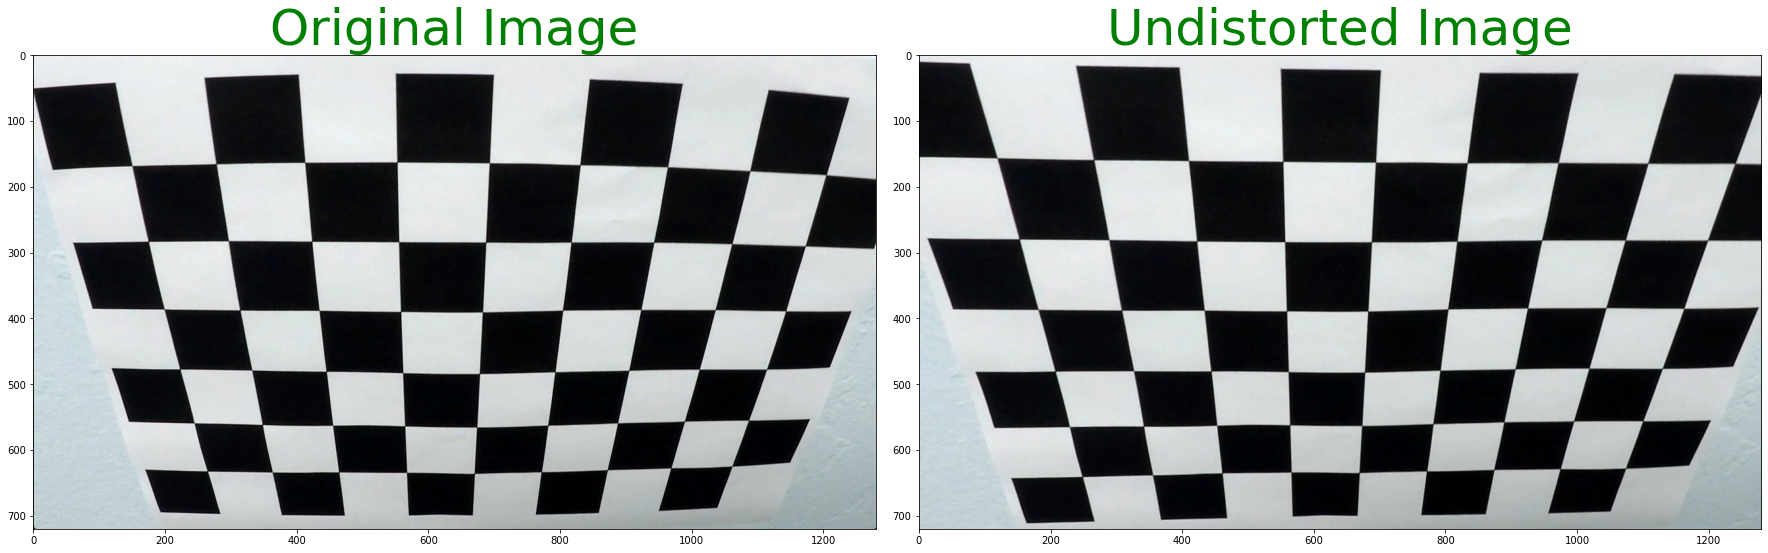

In [3]:
# Getting back the objects:
with open('Resources/camera_params.pkl', 'rb') as f:
    [mtx, dist] = pickle.load(f)

# Original and undistorted image
original = cv2.imread('camera_cal/calibration2.jpg')
undistorted = cv2.undistort(original, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(original)
ax1.set_title('Original Image', fontsize=50, color=(0,0.5,0))
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50, color=(0,0.5,0))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Distortion corrected video frame

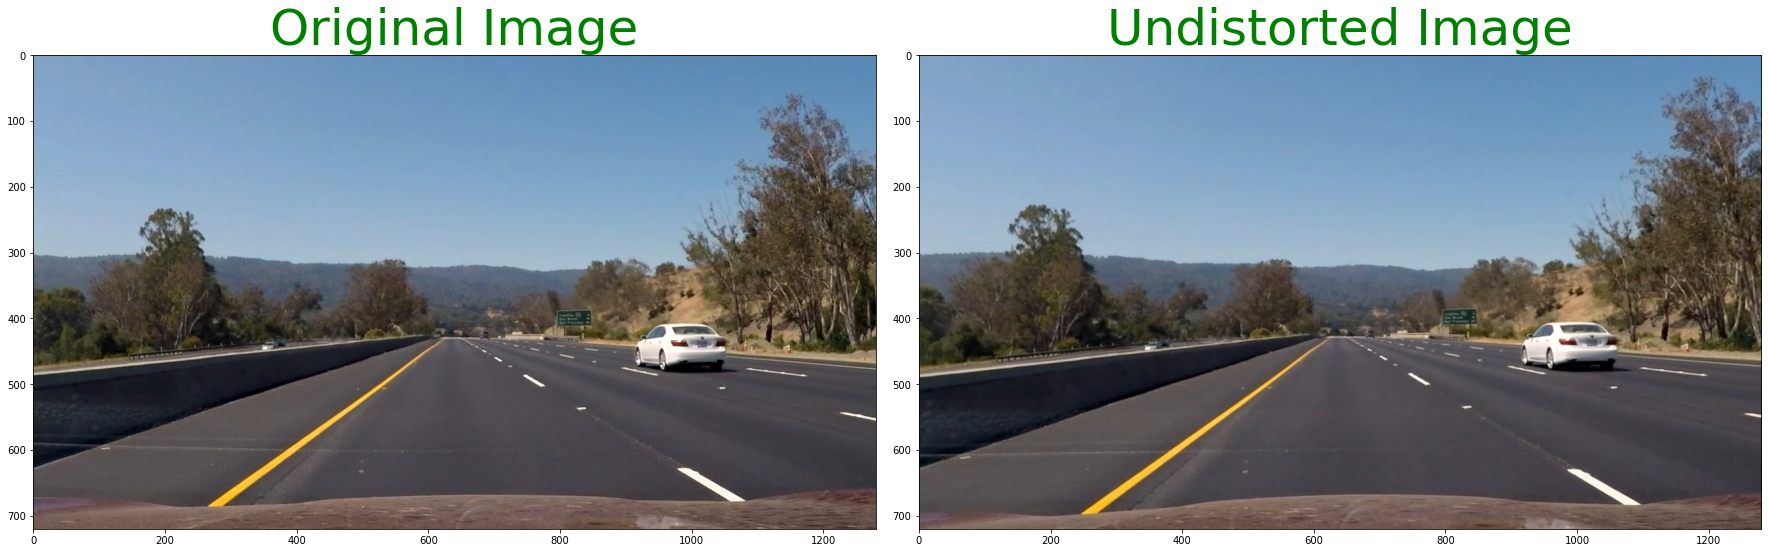

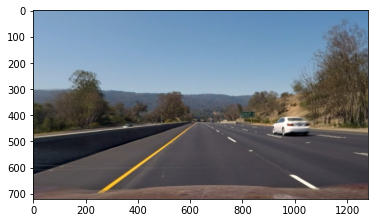

In [4]:
# Original and undistorted image
original = mpimg.imread('my_examples/frame_distorted.jpg')
undistorted = cv2.undistort(original, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(original)
ax1.set_title('Original Image', fontsize=50, color=(0,0.5,0))
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50, color=(0,0.5,0))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Overlay undistorted and original image
plt.figure()
combined_img = cv2.addWeighted(original, 0.5, undistorted, 0.5, 0)
plt.imshow(combined_img)


## Filtering example

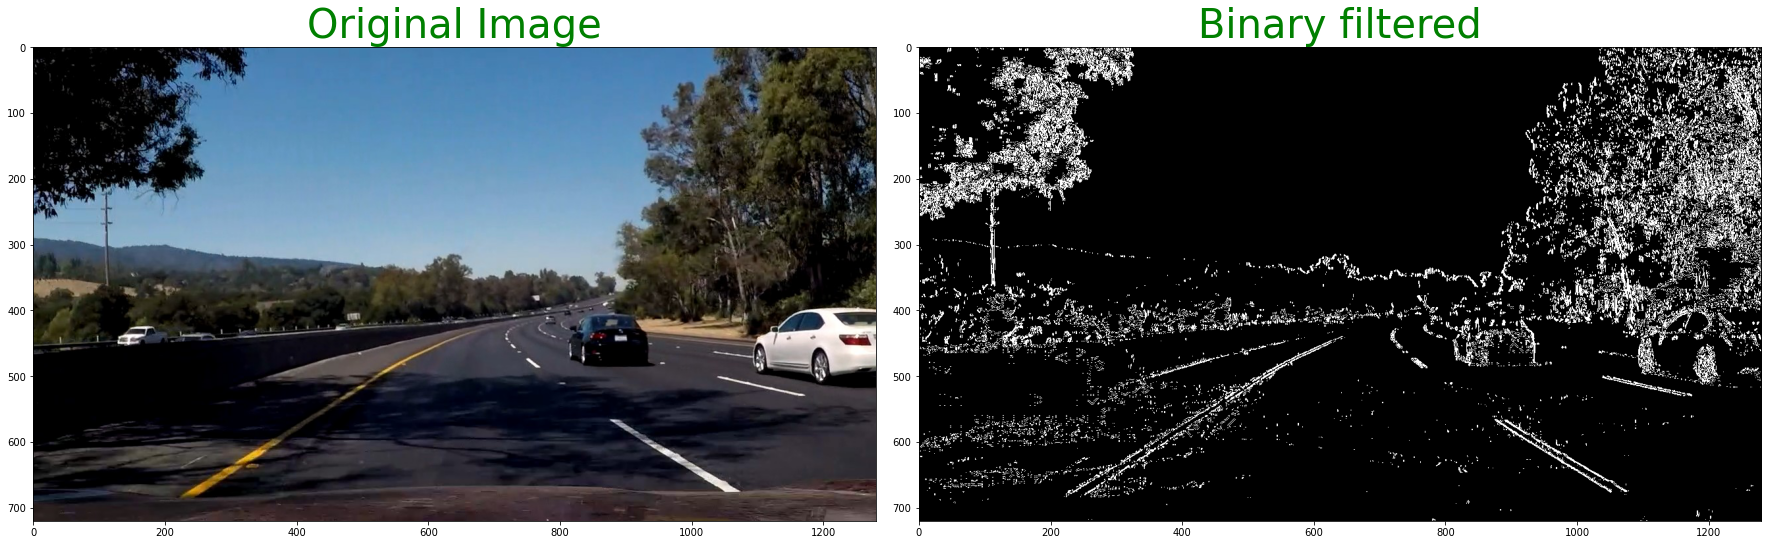

In [6]:
# # Scale the image
# plt.rcParams['figure.dpi'] = 200

with open('Resources/camera_params.pkl', 'rb') as f:
    [mtx, dist] = pickle.load(f)

origonal_img = mpimg.imread('my_examples/challenge_image_1.jpg')
binary_img = helper_functions.filter_image(origonal_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(origonal_img)
ax1.set_title('Original Image', fontsize=40, color=(0,0.5,0))

ax2.imshow(binary_img, cmap = 'gray')
ax2.set_title('Binary filtered', fontsize=40, color=(0,0.5,0))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Transformation to Bird eye view

In [18]:
import pickle
import cv2
import numpy as np

# DL, UL, UR, DR
src = np.float32([[309, 658], [580, 460], [706, 460], [1042, 658]])

# Destination rectangle height will map to full y resolution

# Scale the bottom of the destination rectangle to take right amount
# of space on the sides of the lane to track the curvature, but not
# more that necessary to avoid other objects and lines.
x_length = np.int32((1024 - 312) * 0.9)
x_left = (1280 - x_length) / 2
x_right = 1280 - x_left

dst = np.float32([[x_left, 720], [x_left, 0], [x_right, 0], [x_right, 720]])

# Calculate perspective matrices
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

with open('Resources/lane_perspective.pkl', 'wb') as f:
    pickle.dump([src, dst, M, Minv], f)

<Figure size 432x288 with 0 Axes>

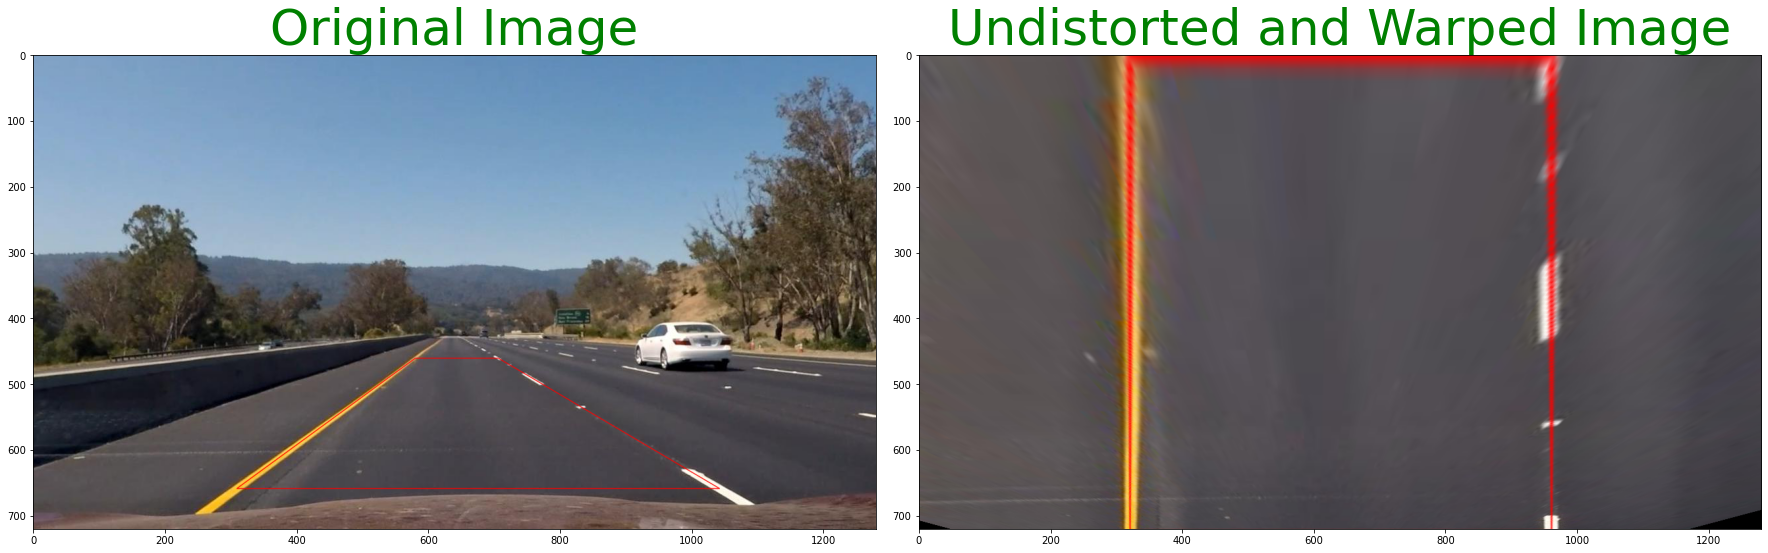

In [19]:
with open('Resources/lane_perspective.pkl', 'rb') as f:
    [src, dst, M, Minv] = pickle.load(f)

# Read in an image
undistorted = mpimg.imread('my_examples/frame_undistorted.jpg')
im_size = undistorted.shape[1::-1]

# Plot region rectangle on the image
helper_functions.draw_polyline(undistorted, [globals.lane_params.lane_region], Closed = True, thickness=1)

warped = cv2.warpPerspective(undistorted, M, im_size, flags=cv2.INTER_LINEAR)

plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50, color=(0,0.5,0))
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50, color=(0,0.5,0))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Pipeline

In [8]:

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import helper_functions
import globals

with open('Resources/camera_params.pkl', 'rb') as f:
    [mtx, dist] = pickle.load(f)

with open('Resources/lane_perspective.pkl', 'rb') as f:
    [src, dst, M, Minv] = pickle.load(f)

lane_params = globals.lane_params
lane_params.detected_lanes = []

# Filtering parameters
globals.lane_params.l_thresh = (20, 80)
globals.lane_params.s_thresh = (20, 80)

# Road radius estimation
lane_params.frame_counter = 0
road_radius = []

def process_image(image):

    # Undistort the image
    undst = cv2.undistort(image, mtx, dist, None, mtx)

    # Filter image
    filtered = helper_functions.filter_image(undst, lane_params.l_thresh, lane_params.s_thresh)

    # Warp perspective
    binary_warped = cv2.warpPerspective(filtered, M, lane_params.img_shape[1::-1], flags=cv2.INTER_LINEAR)   
    # Detect lanes
    left_x, left_y, right_x, right_y, best_fit = helper_functions.fit_poly_to_lanes(binary_warped)

    # Visualization
    lane_visualization = helper_functions.plot_lanes(undst, Minv, best_fit.left_fit, best_fit.right_fit)

    # For debugging
    # lane_visualization = helper_functions.plot_debug(binary_warped, left_x, left_y, right_x, right_y,
    #             best_fit.left_fit, best_fit.right_fit, 50)                

    position = helper_functions.position_measurement(best_fit.left_fit, best_fit.right_fit, lane_params)    

    # Display lane curvature and vehicle offset from the middle of the lane
    helper_functions.draw_label(lane_visualization, "Position[m]: %f" % position, (1000, 50))

    # Calculate the curvature from 4-7th second of the video
    if lane_params.frame_counter >= 24 * 3 and lane_params.frame_counter < 24 * 6:
        left_curverad, right_curverad = helper_functions.radius_measurements(best_fit.left_fit, best_fit.right_fit, lane_params)
        road_radius.append([left_curverad, right_curverad])
    
    lane_params.frame_counter = lane_params.frame_counter + 1

    return lane_visualization


In [9]:
white_output = 'output_videos/project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4") #.subclip(19,23)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)   #%time 

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]Moviepy - Building video output_videos/project_video_out.mp4.
Moviepy - Writing video output_videos/project_video_out.mp4

Moviepy - Done !
Moviepy - video ready output_videos/project_video_out.mp4


# Analyse lane curvature

In [22]:

# Average of the lane curve from the 4 - 7 seconds of the video 'project_video.mp4'
print("Averaged lane curve: %f m" % np.average(road_radius))


Averaged lane curve: 1270.033268 m
